In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # optional, for tabular summaries
# Re-run the simulation multiple times to estimate mean and variance of each estimator
num_runs = 500  # number of repetitions
theta_true = 2.0
n_values = np.arange(100, 5001, 100)

# Initialize dictionary to store multiple runs
all_runs = {key: [] for key in [
    "DR: both good (0.3 + 0.3)",  # 0 
    "DR: one bad (0.05 + 0.3)",   # 1
    "DR: both bad (0.05 + 0.05)", # 2
    "T-Learner (RF-style, slow)", # 3
    "T-Learner (LR-style, fast)"  # 4
]}

# Define true functions
def f_true(x):
    return np.sin(x)

def e_true(x):
    return 1 / (1 + np.exp(-2 * x))

def noisy_estimate(true_func, x, rate):
    noise = np.random.normal(0, 1, size=x.shape) * (len(x) ** -rate)
    return true_func(x) + noise

def estimate_dr_ate(Y, T, e_hat, m0_hat, m1_hat):
    """
    Compute doubly robust (AIPW) estimate of ATE:
        θ̂ = mean[(T - ê)/(ê(1-ê)) * (Y - m̂_T(X)) + m̂₁(X) - m̂₀(X)]
    """
    # Ensure shapes match
    e_hat = e_hat.reshape(-1, 1)
    m_hat = T * m1_hat + (1 - T) * m0_hat
    score = ((T - e_hat) / (e_hat * (1 - e_hat))) * (Y - m_hat) + (m1_hat - m0_hat)
    return np.mean(score)

# Run simulations
for _ in range(num_runs):
    run_results = {key: [] for key in all_runs}
    for n in n_values:
        X = np.random.normal(0, 1, size=(n, 1))
        T = np.random.binomial(1, e_true(X))
        Y = theta_true * T + f_true(X) + np.random.normal(0, 1, size=(n, 1))

        # DR: both good (0.3 + 0.3)
        f0 = noisy_estimate(f_true, X, 0.3)
        f1 = f0 + theta_true
        e_hat = noisy_estimate(e_true, X, 0.3)
        run_results["DR: both good (0.3 + 0.3)"].append(estimate_dr_ate(Y, T, e_hat, f0, f1))

        # DR: one bad (0.05 + 0.3)
        f0 = noisy_estimate(f_true, X, 0.05)
        f1 = f0 + theta_true
        e_hat = noisy_estimate(e_true, X, 0.3)
        run_results["DR: one bad (0.05 + 0.3)"].append(estimate_dr_ate(Y, T, e_hat, f0, f1))

        # DR: both bad (0.05 + 0.05)
        f0 = noisy_estimate(f_true, X, 0.05)
        f1 = f0 + theta_true
        e_hat = noisy_estimate(e_true, X, 0.05)
        run_results["DR: both bad (0.05 + 0.05)"].append(estimate_dr_ate(Y, T, e_hat, f0, f1))

        # T-Learner (RF-style, slow)
        f1_hat_slow = noisy_estimate(f_true, X, 0.1) + theta_true
        f0_hat_slow = noisy_estimate(f_true, X, 0.1)
        cate_slow = f1_hat_slow - f0_hat_slow
        run_results["T-Learner (RF-style, slow)"].append(np.mean(cate_slow))

        # T-Learner (LR-style, fast)
        f1_hat_fast = noisy_estimate(f_true, X, 0.3) + theta_true
        f0_hat_fast = noisy_estimate(f_true, X, 0.3)
        cate_fast = f1_hat_fast - f0_hat_fast
        run_results["T-Learner (LR-style, fast)"].append(np.mean(cate_fast))

    for key in all_runs:
        all_runs[key].append(run_results[key])




In [24]:
# Calculate means and standard deviations
means = {key: np.mean(all_runs[key], axis=0) for key in all_runs}
stds = {key: np.std(all_runs[key], axis=0) for key in all_runs}

# First list entries of means and stds
keys = list(means.keys())
selected_indices = [0]


means = {keys[i]: means[keys[i]] for i in selected_indices}
stds = {keys[i]: stds[keys[i]] for i in selected_indices}


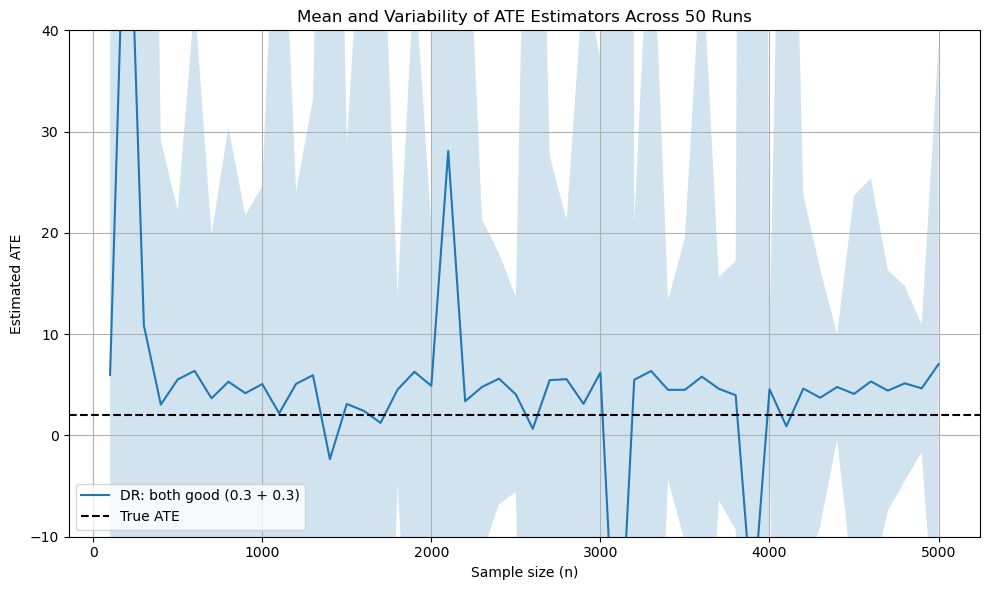

In [26]:

# Plot with error bands
plt.figure(figsize=(10, 6))
for key in means:
    plt.plot(n_values, means[key], label=key)
    plt.fill_between(n_values, means[key] - stds[key], means[key] + stds[key], alpha=0.2)

plt.axhline(theta_true, color='black', linestyle='--', label="True ATE")
plt.xlabel("Sample size (n)")
plt.ylabel("Estimated ATE")
plt.ylim(-10, 40)
plt.title("Mean and Variability of ATE Estimators Across 50 Runs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()